#Carga de librerías necesarias

In [ ]:
import pandas as pd
import io
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from numpy import corrcoef, transpose, arange
import itertools
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from itertools import cycle
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from numpy.random import seed
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit() 
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statistics as stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder


#Carga y selección de datos

En local

In [ ]:
train =  pd.read_excel('N001_hora.xlsx')

Desde mi drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train =  pd.read_excel('/content/drive/MyDrive/N001_hora.xlsx')

In [ ]:
train.shape

(126336, 12)

In [ ]:
train.head()

In [ ]:
train.tail()

In [ ]:
train.info()

In [ ]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100,2)))

In [ ]:
train_over = train.copy()

In [ ]:
train_over= train_over[train_over.Fecha >= '2019-01-01']
train_over.reset_index(drop = True, inplace = True)

In [ ]:
train_over.shape


(29904, 12)

In [ ]:
train_over.head()

,Fecha,Nivel,Caudal,Precipitación,Temp_aire,Temp_agua,Turbidez,Conductividad,pH,Ox_disuelto,N_amoniacal,Absorb_agua
0,2019-01-01 00:00:00,1.27,39.32,0.0,0.8,7.6,2.0,75.0,6.6,11.3,0.0,4.0
1,2019-01-01 01:00:00,1.27,39.32,0.0,0.4,7.5,3.0,75.0,6.6,11.3,0.0,4.0
2,2019-01-01 02:00:00,1.27,39.32,0.0,0.1,7.5,2.0,75.0,6.5,11.3,0.0,4.0
3,2019-01-01 03:00:00,1.26,38.06,0.0,0.2,7.4,2.0,75.0,6.5,11.3,0.0,4.0
4,2019-01-01 04:00:00,1.26,38.06,0.0,0.2,7.4,2.0,76.0,6.5,11.3,0.0,3.9


In [ ]:
train_over.tail()

In [ ]:
train_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          29904 non-null  datetime64[ns]
 1   Nivel          29900 non-null  float64       
 2   Caudal         29900 non-null  float64       
 3   Precipitación  29904 non-null  float64       
 4   Temp_aire      29900 non-null  float64       
 5   Temp_agua      29570 non-null  float64       
 6   Turbidez       29581 non-null  float64       
 7   Conductividad  29571 non-null  float64       
 8   pH             29569 non-null  float64       
 9   Ox_disuelto    29459 non-null  float64       
 10  N_amoniacal    27846 non-null  float64       
 11  Absorb_agua    28458 non-null  float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 2.7 MB


#Limpieza de valores nulos

In [ ]:
for col in train_over.columns:
    pct_missing = np.mean(train_over[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100,2)))

In [ ]:
pd.isnull(train_over).any()

In [ ]:
train_over.isnull().sum()

In [ ]:
train_over ['Conductividad'] = train_over['Conductividad'].interpolate().ffill().bfill()
train_over ['pH'] = train_over['pH'].interpolate().ffill().bfill()
train_over ['Ox_disuelto'] = train_over['Ox_disuelto'].interpolate().ffill().bfill()
train_over ['N_amoniacal'] = train_over['N_amoniacal'].interpolate().ffill().bfill()
train_over ['Absorb_agua'] = train_over['Absorb_agua'].interpolate().ffill().bfill()
train_over ['Turbidez'] = train_over['Turbidez'].interpolate().ffill().bfill()
train_over ['Nivel'] = train_over['Nivel'].interpolate().ffill().bfill()
train_over ['Caudal'] = train_over['Caudal'].interpolate().ffill().bfill()
train_over ['Temp_agua'] = train_over['Temp_agua'].interpolate().ffill().bfill()
train_over ['Temp_aire'] = train_over['Temp_aire'].interpolate().ffill().bfill()
pd.isnull(train_over).any()

Fecha            False
Nivel            False
Caudal           False
Precipitación    False
Temp_aire        False
Temp_agua        False
Turbidez         False
Conductividad    False
pH               False
Ox_disuelto      False
N_amoniacal      False
Absorb_agua      False
dtype: bool

#Creación/Transformación de variables

In [ ]:
train_over['Turbidez']=train_over['Turbidez'].astype(np.int64)

In [ ]:
#train_over['hora'] = [ fecha.hour for fecha in train_over.Fecha ]

In [ ]:
#train_over['año'] = [ fecha.year for fecha in train_over.Fecha ]

In [ ]:
train_over['mes'] = [ fecha.month for fecha in train_over.Fecha ]

In [ ]:
train_over['estacion']=train_over['mes']

In [ ]:
for i in range (0,len(train_over.estacion)):
  if train_over.estacion[i] <3:
    train_over['estacion'][i]='Invierno'
  elif 3 < train_over.estacion[i] < 6:
    train_over['estacion'][i]='Primavera'
  elif 6 < train_over.estacion[i] < 9:
    train_over['estacion'][i]='Verano'
  elif 9 < train_over.estacion[i] < 12:
    train_over['estacion'][i]='Otoño'
  elif train_over.estacion[i] == 3:
    if train_over.Fecha[i].day < 21:
      train_over['estacion'][i]='Invierno'
    else:
      train_over['estacion'][i]='Primavera'
  elif train_over.estacion[i] == 6:
    if train_over.Fecha[i].day < 21:
      train_over['estacion'][i]='Primavera'
    else:
      train_over['estacion'][i]='Verano'
  elif train_over.estacion[i] == 9:
    if train_over.Fecha[i].day < 23:
      train_over['estacion'][i]='Verano'
    else:
      train_over['estacion'][i]='Otoño'
  elif train_over.estacion[i] == 12:
    if train_over.Fecha[i].day < 21:
      train_over['estacion'][i]='Otoño'
    else:
      train_over['estacion'][i]='Invierno'

In [ ]:
for i in range (0,len(train_over.mes)):
  if train_over.mes[i] == 1:
    train_over['mes'][i]='Enero'
  elif train_over.mes[i] == 2:
    train_over['mes'][i]='Febrero'
  elif train_over.mes[i] == 3:
    train_over['mes'][i]='Marzo'
  elif train_over.mes[i] == 4:
    train_over['mes'][i]='Abril'
  elif train_over.mes[i] == 5:
    train_over['mes'][i]='Mayo'
  elif train_over.mes[i] == 6:
    train_over['mes'][i]='Junio'
  elif train_over.mes[i] == 7:
    train_over['mes'][i]='Julio'
  elif train_over.mes[i] == 8:
    train_over['mes'][i]='Agosto'
  elif train_over.mes[i] == 9:
    train_over['mes'][i]='Septiembre'
  elif train_over.mes[i] == 10:
    train_over['mes'][i]='Octubre'
  elif train_over.mes[i] == 11:
    train_over['mes'][i]='Noviembre'
  else: 
    train_over['mes'][i]='Diciembre'

In [ ]:
train_over['Turb_lag'] = train_over['Turbidez'].shift(1)
train_over.Turb_lag[0]=2

In [ ]:
train_over['Turb_dif'] = train_over['Turbidez'].shift(1)-train_over['Turbidez'].shift(2)
train_over.Turb_dif[0]=-1
train_over.Turb_dif[1]=0

In [ ]:
train_over['Caudal_dif'] = train_over['Caudal'].diff(1)
train_over.Caudal_dif[0]=0

In [ ]:
train_over['Caudal_min24'] = train_over['Caudal_max24'] = train_over.Caudal
for i in range (1,24):
  train_over['Caudal_min24'][i] = train_over.Caudal[0:i+1].min()
  train_over['Caudal_max24'][i] = train_over.Caudal[0:i+1].max()
for i in range (24,len(train_over.Caudal)):
  train_over['Caudal_min24'][i] = train_over.Caudal[i-23:i+1].min()
  train_over['Caudal_max24'][i] = train_over.Caudal[i-23:i+1].max()

In [ ]:
train_over['Caudal_dif_min']= train_over.Caudal - train_over.Caudal_min24
train_over['Caudal_dif_max']= train_over.Caudal - train_over.Caudal_max24
train_over = train_over.drop('Caudal_min24',axis=1)
train_over = train_over.drop('Caudal_max24',axis=1)

In [ ]:
train_over['Caudal_mean48'] = train_over.Caudal
for i in range (1,48):
  train_over['Caudal_mean48'][i] = round(train_over.Caudal[0:i+1].mean(),2)
for i in range (48,len(train_over.Caudal)):
  train_over['Caudal_mean48'][i] = round(train_over.Caudal[i-47:i+1].mean(),2)
 

In [ ]:
train_over['Caudal_dif_med48']=train_over.Caudal - train_over.Caudal_mean48
train_over = train_over.drop('Caudal_mean48',axis=1)

In [ ]:
train_over['Lluvia_diaria']=train_over['Precipitación']

In [ ]:
for i in range (1,24):
  train_over['Lluvia_diaria'][i]=round(train_over['Lluvia_diaria'][i],1)+round(train_over['Lluvia_diaria'][i-1],1)
for i in range (24,len(train_over.Precipitación)):
  train_over['Lluvia_diaria'][i]=round(train_over['Precipitación'][i],1)+round(train_over['Lluvia_diaria'][i-1],1)-round(train_over['Precipitación'][i-24],1)


In [ ]:
train_over['Intensidad_lluvia'] = 'Inexistente'

In [ ]:
for i in range (0,len(train_over.Precipitación)):
  if ((0 < train_over.Precipitación[i] < 2.0) and (train_over.Lluvia_diaria[i] < 5.0)) or ((0.0 < train_over.Lluvia_diaria[i] < 5.0) and (train_over.Precipitación[i] < 2.0)):
    train_over['Intensidad_lluvia'][i]= 'Debil'
  elif (train_over.Precipitación[i] >= 8.6) or (train_over.Lluvia_diaria[i] >= 20.0):
    train_over['Intensidad_lluvia'][i]= 'Moderada-Fuerte'
  elif ((2.0 <= train_over.Precipitación[i] < 8.6) and (train_over.Lluvia_diaria[i] < 20.0)) or ((5.0 <= train_over.Lluvia_diaria[i] < 20.0) and (train_over.Precipitación[i] < 8.6)):
    train_over['Intensidad_lluvia'][i]= 'Moderada-Leve'


In [ ]:
train_over['sequia']=0

In [ ]:
if train_over.Precipitación[0] == 0:
  train_over['sequia'][0]= 1
for i in range (1,len(train_over.sequia)):
  if train_over.Precipitación[i] == 0:
    train_over['sequia'][i]= train_over['sequia'][i-1] + 1

In [ ]:
train_over['dias_sequia']= train_over['sequia'] // 24
train_over = train_over.drop('sequia',axis=1)

In [ ]:
train_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              29904 non-null  datetime64[ns]
 1   Nivel              29904 non-null  float64       
 2   Caudal             29904 non-null  float64       
 3   Precipitación      29904 non-null  float64       
 4   Temp_aire          29904 non-null  float64       
 5   Temp_agua          29904 non-null  float64       
 6   Turbidez           29904 non-null  int64         
 7   Conductividad      29904 non-null  float64       
 8   pH                 29904 non-null  float64       
 9   Ox_disuelto        29904 non-null  float64       
 10  N_amoniacal        29904 non-null  float64       
 11  Absorb_agua        29904 non-null  float64       
 12  mes                29904 non-null  object        
 13  estacion           29904 non-null  object        
 14  Turb_l

In [ ]:
#train_over = pd.get_dummies(train_over, prefix=['meses','estaciones', 'Intensidad'])

In [ ]:
#train_over = pd.get_dummies(train_over, prefix=['estaciones', 'Intensidad'],columns=['estacion','Intensidad_lluvia'])

In [ ]:
train_over = pd.get_dummies(train_over, prefix=['estaciones'],columns=['estacion'])

In [ ]:
train_over = pd.get_dummies(train_over, prefix=['Intensidad'],columns=['Intensidad_lluvia'])

In [ ]:
'''labelencoder = LabelEncoder()
train_over['Intensidad_lluvia'] = labelencoder.fit_transform(train_over['Intensidad_lluvia'])
labelencoder.fit_transform()
#train_over['estacion'] = labelencoder.fit_transform(train_over['estacion'])
train_over.head()'''

#EDA

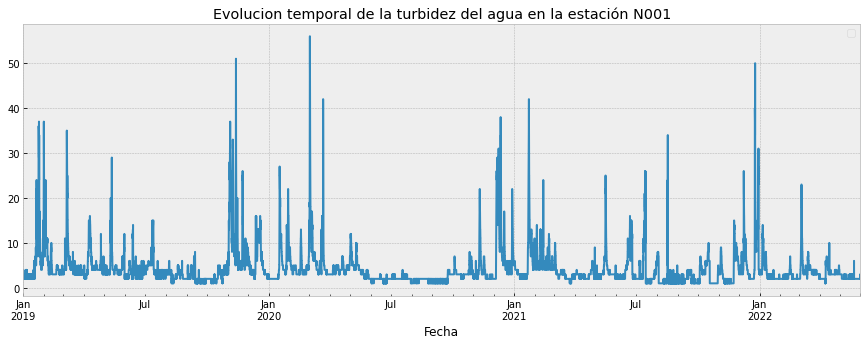

In [ ]:
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
train_over \
    .set_index('Fecha')['Turbidez'] \
    .T \
    .plot(figsize=(15, 5),
          title='Evolucion temporal de la turbidez del agua en la estación N001',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
train_over['Turbidez'][train_over['Turbidez']>=15].count()

866

In [ ]:
train_over['Turbidez'][train_over['Turbidez']>=25].count()

282

In [ ]:
train_over.describe()

,Nivel,Caudal,Precipitación,Temp_aire,Temp_agua,Turbidez,Conductividad,pH,Ox_disuelto,N_amoniacal,Absorb_agua,Turb_lag,Turb_dif,Caudal_dif,Caudal_dif_min,Caudal_dif_max,Caudal_dif_med48,Lluvia_diaria,dias_sequia
count,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000,29904.000000
mean,1.314366,55.419713,0.121743,13.080101,13.840155,4.156835,88.237844,7.030327,9.520914,0.002445,3.243411,4.156835,-0.000033,-0.000779,6.001102,-6.250314,-0.017332,2.921830,3.040028
std,0.384663,73.096522,0.592126,6.752564,4.764079,4.141498,23.964379,0.478862,1.412393,0.014875,1.634898,4.141498,0.775830,1.741371,23.299422,17.981595,25.400971,6.654126,4.734220
min,0.910000,4.070000,0.000000,-5.300000,4.100000,1.000000,43.000000,5.300000,3.900000,0.000000,0.800000,1.000000,-32.000000,-17.090000,0.000000,-248.160000,-176.780000,0.000000,0.000000
25%,1.050000,15.090000,0.000000,8.400000,10.018750,2.000000,73.000000,6.700000,8.500000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,-3.480000,-2.420000,0.000000,0.000000
50%,1.210000,31.940000,0.000000,12.700000,12.900000,3.000000,83.000000,7.000000,9.600000,0.000000,2.800000,3.000000,0.000000,0.000000,0.000000,-1.160000,-0.640000,0.000000,1.000000
75%,1.420000,60.170000,0.000000,17.300000,17.800000,4.000000,96.000000,7.300000,10.600000,0.000000,4.100000,4.000000,0.000000,0.000000,1.190000,0.000000,0.370000,2.300000,4.000000
max,3.430000,580.660000,19.500000,39.400000,26.800000,56.000000,189.000000,9.000000,12.900000,0.280000,27.500000,56.000000,22.000000,33.540000,344.450000,0.000000,308.990000,63.100000,31.000000


In [ ]:
train_over.describe(include='object')

,mes,estacion,Intensidad_lluvia
count,29904,29904,29904
unique,12,4,4
top,Enero,Invierno,Inexistente
freq,2976,8400,17137


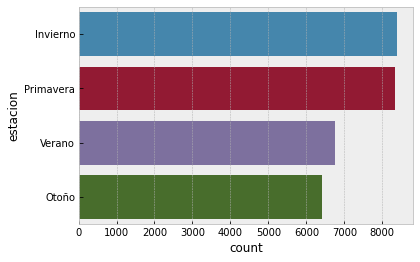

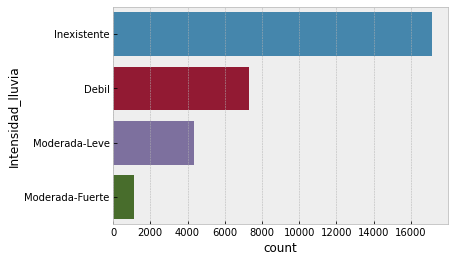

In [ ]:
for column in train_over.select_dtypes(include='object'):
    if train_over[column].nunique() < 10:
        sns.countplot(y=column, data=train_over)
        plt.show()
  

Text(0.5, 1.0, 'Turbidez media según la estacion del año')

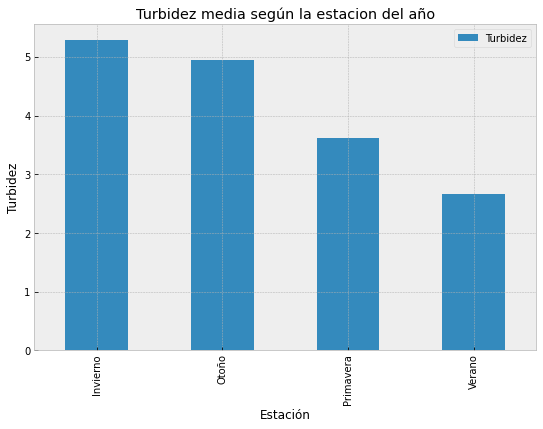

In [ ]:
plot=train_over.pivot_table(['Turbidez'], ['estacion'], aggfunc='mean').plot(kind='bar',figsize=(9,6))
plt.ylabel('Turbidez', fontsize=12)
plt.xlabel('Estación', fontsize=12)
plt.title('Turbidez media según la estacion del año')

Text(0.5, 1.0, 'Turbidez según mes del año')

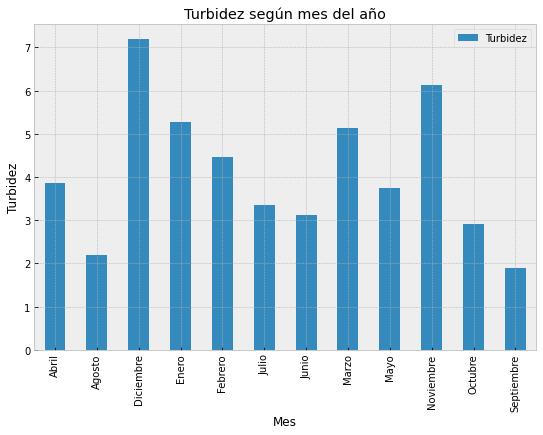

In [ ]:
plot=train_over.pivot_table(['Turbidez'], ['mes'], aggfunc='mean').plot(kind='bar',figsize=(9,6))
plt.ylabel('Turbidez', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.title('Turbidez según mes del año')

Text(0.5, 0, 'Intensidad de lluvia')

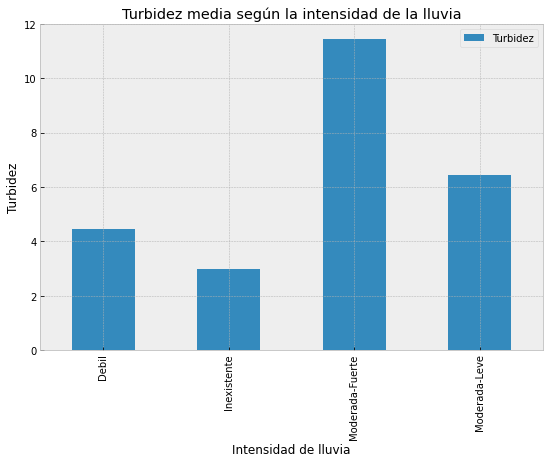

In [ ]:
plot=train_over.pivot_table(['Turbidez'], ['Intensidad_lluvia'], aggfunc='mean').plot(kind='bar',figsize=(9,6))
plt.title('Turbidez media según la intensidad de la lluvia')
plt.ylabel('Turbidez', fontsize=12)
plt.xlabel('Intensidad de lluvia', fontsize=12)

In [ ]:
corr_cruz=sm.tsa.stattools.ccf(train_over.Turbidez, train_over.Precipitación,adjusted=False )
corr_cruz[0:12]

array([0.11967998, 0.1258157 , 0.1326813 , 0.13736742, 0.1425213 ,
       0.15090846, 0.16081809, 0.17274568, 0.18710169, 0.20238637,
       0.21727831, 0.23175569])

In [ ]:
corr_cruz=sm.tsa.stattools.ccf(train_over.Turbidez, train_over.Lluvia_diaria,adjusted=False )
corr_cruz[0:12]

array([0.46657888, 0.47997521, 0.4925458 , 0.50412578, 0.51512717,
       0.52523239, 0.53421301, 0.54186313, 0.54799162, 0.55238009,
       0.55498218, 0.55559171])

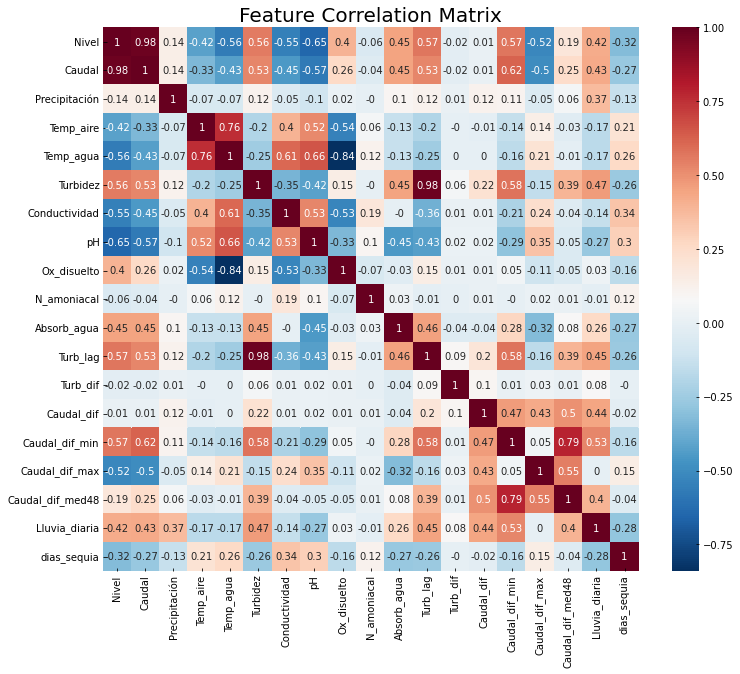

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(round(train_over.corr(),2), annot=True, cmap='RdBu_r') # El True es para incluir el valor numerico de cada correlación, otro cmap='RdBu_r'(es para los colores)
plt.title("Feature Correlation Matrix",fontsize=20)
plt.show()

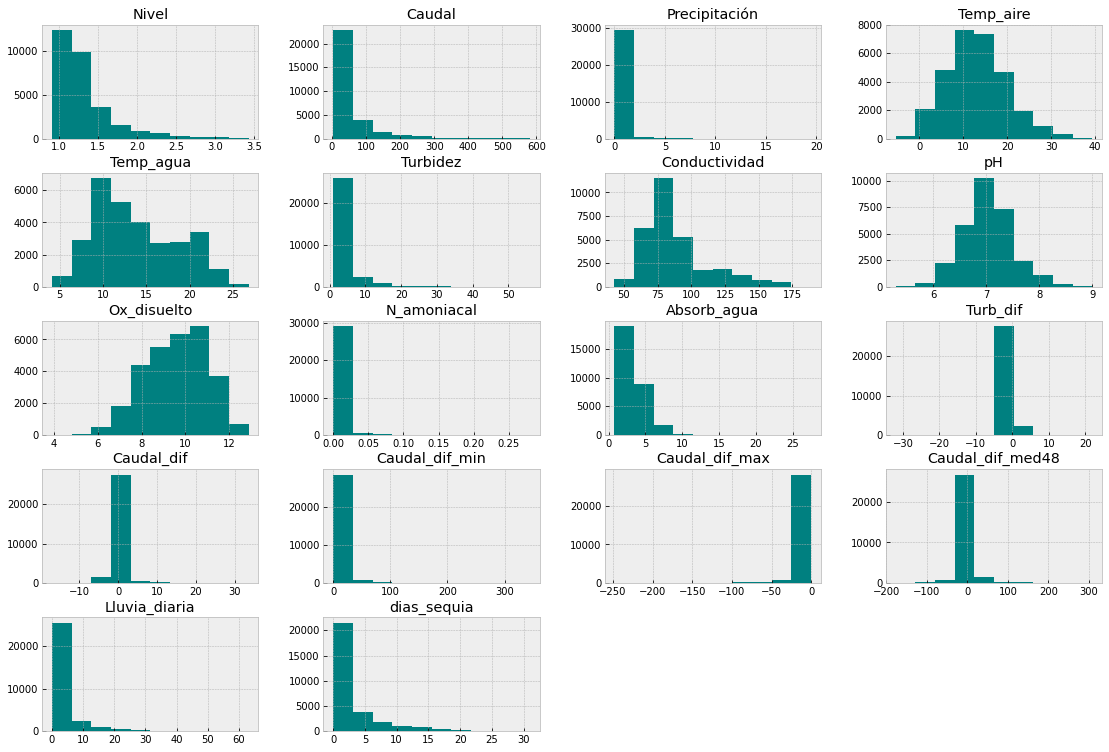

In [ ]:
cols_to_drop=['Fecha','Turb_lag']
train_over.drop(cols_to_drop,axis=1).hist(figsize=(19,13),color="#008080")
plt.show()

Text(0.5, 1.0, 'Histograma de la turbidez')

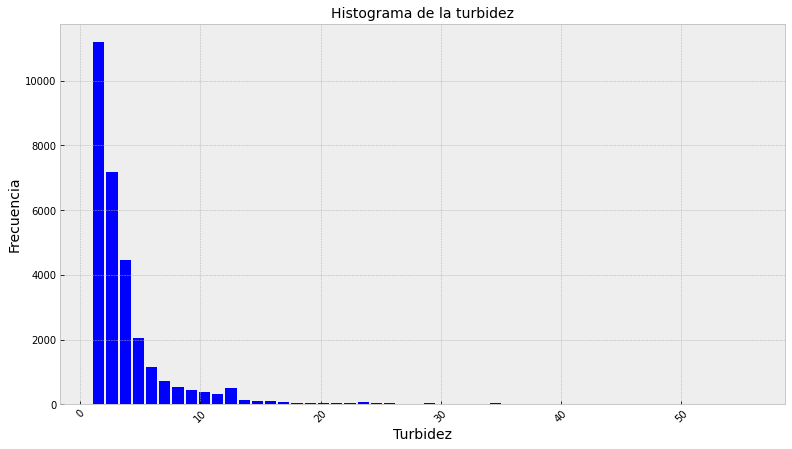

In [ ]:
train_over['Turbidez'].hist(figsize=(13,7), color="blue", xrot=45, bins=50,rwidth=0.85) 
plt.ylabel('Frecuencia', fontsize=14)
plt.xlabel('Turbidez', fontsize=14)
plt.title('Histograma de la turbidez', fontsize=14)

Text(0.5, 0, 'Turbidez')

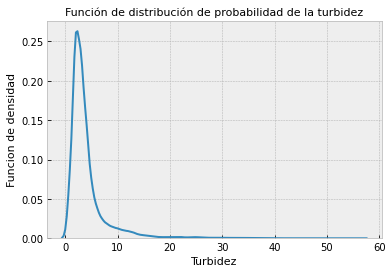

In [ ]:
sns.kdeplot(train_over['Turbidez'])
plt.title('Función de distribución de probabilidad de la turbidez', fontsize=11)
plt.ylabel('Funcion de densidad', fontsize=11)
plt.xlabel('Turbidez', fontsize=11)

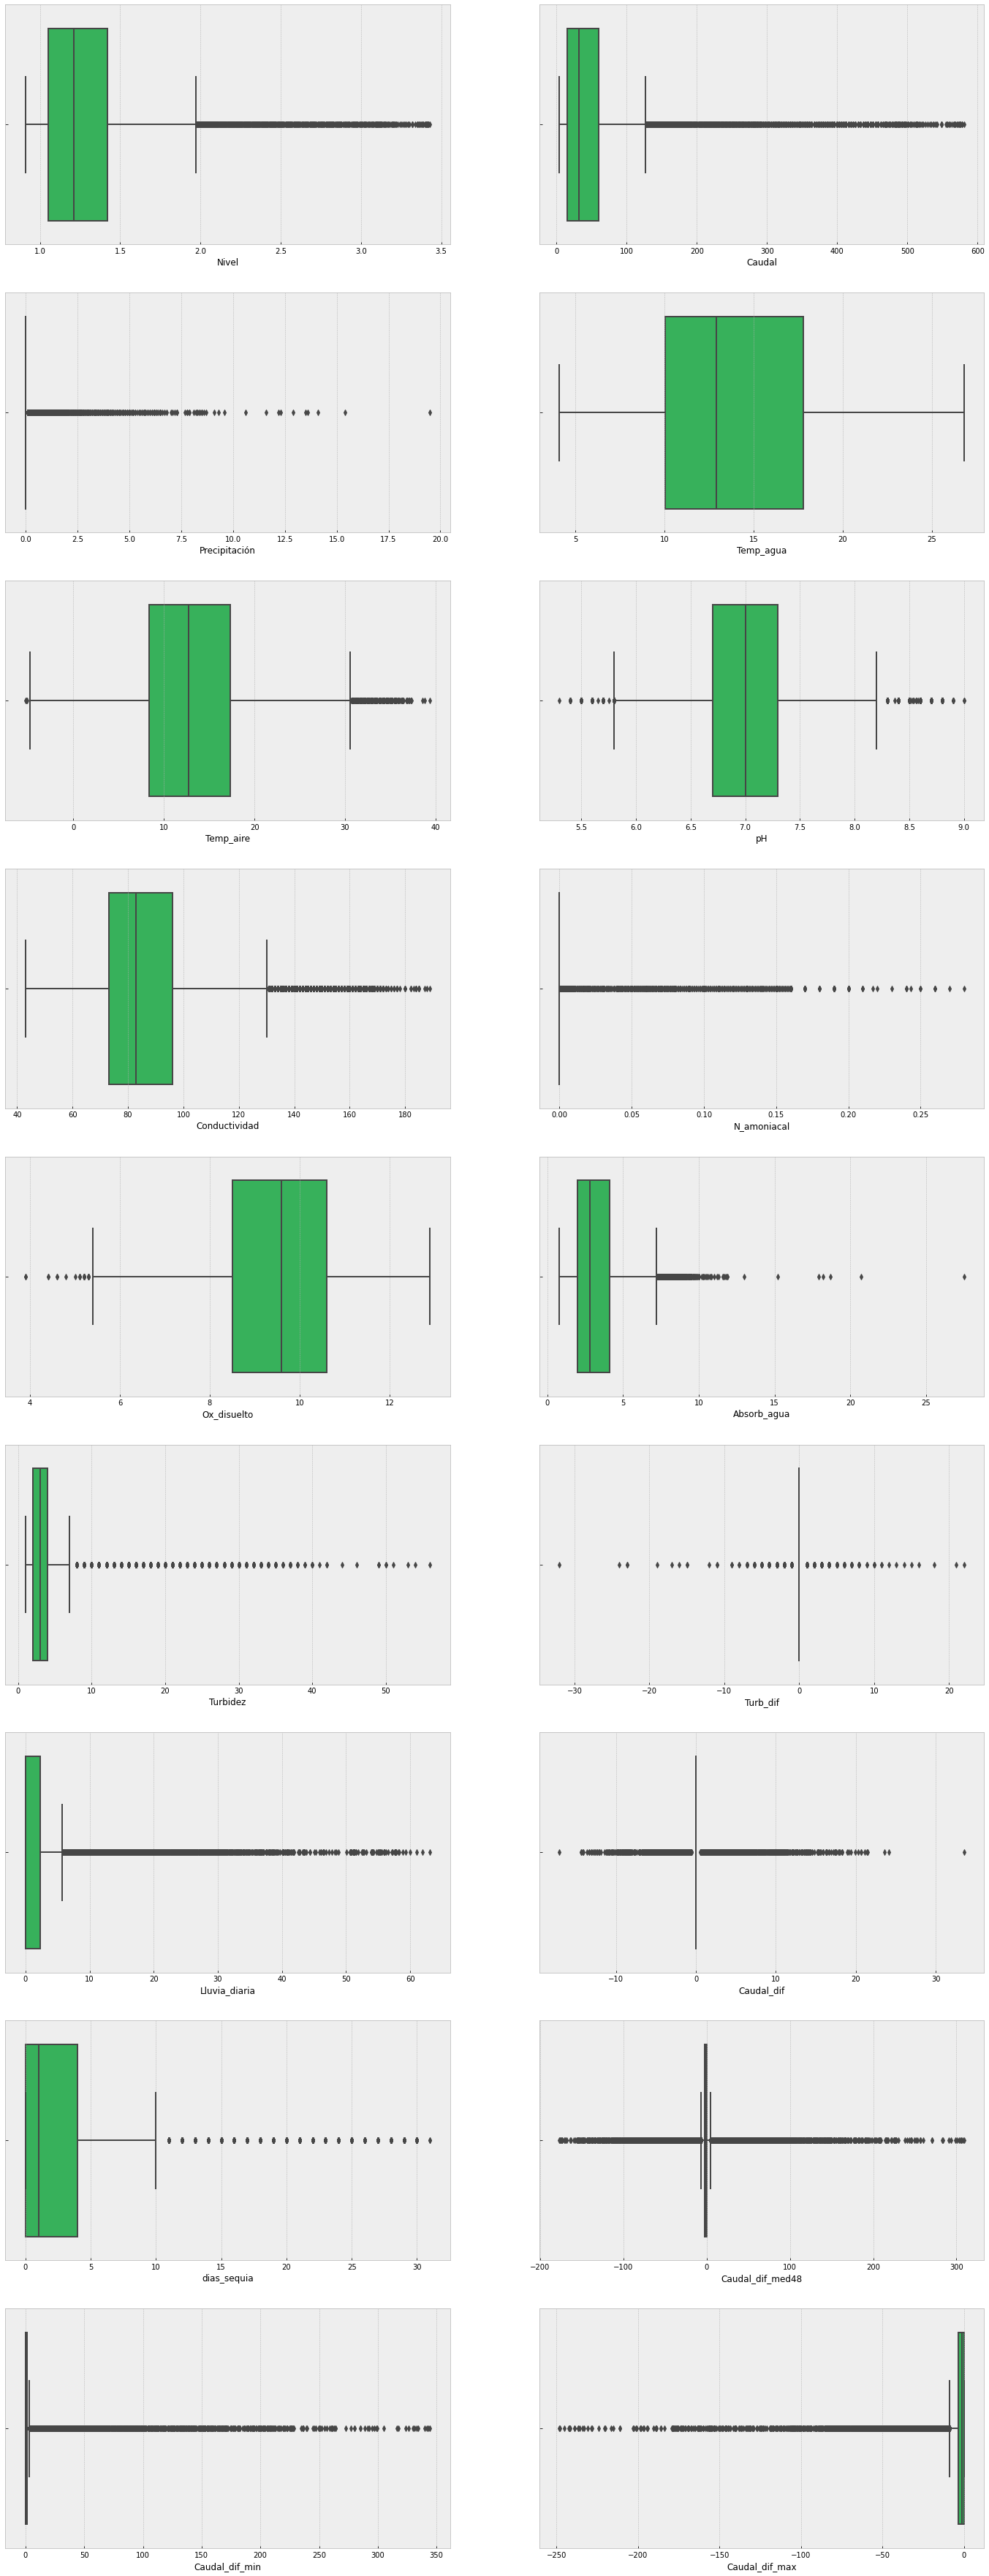

In [ ]:
fig, axes = plt.subplots(9, 2, figsize=(24, 64))#Añadir Turb_dif Lluvia_48h,dias_sequia
#fig.suptitle('Boxplots', fontsize=16)
sns.boxplot(ax=axes[0, 0], x=train_over['Nivel'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[0, 1], x=train_over['Caudal'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[1, 0], x=train_over['Precipitación'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[1, 1], x=train_over['Temp_agua'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[2, 0], x=train_over['Temp_aire'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[2, 1], x=train_over['pH'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[3, 0], x=train_over['Conductividad'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[3, 1], x=train_over['N_amoniacal'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[4, 0], x=train_over['Ox_disuelto'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[4, 1], x=train_over['Absorb_agua'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[5, 0], x=train_over['Turbidez'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[5, 1], x=train_over['Turb_dif'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[6, 0], x=train_over['Lluvia_diaria'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[6, 1], x=train_over['Caudal_dif'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[7, 0], x=train_over['dias_sequia'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[7, 1], x=train_over['Caudal_dif_med48'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[8, 0], x=train_over['Caudal_dif_min'],palette=('#23C552','#C52219'))
sns.boxplot(ax=axes[8, 1], x=train_over['Caudal_dif_max'],palette=('#23C552','#C52219'))


Text(0.5, 0, 'Turbidez')

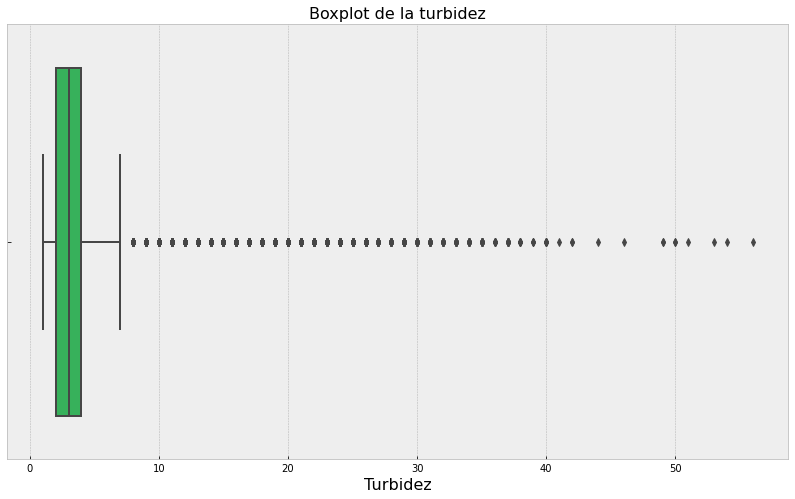

In [ ]:
plt.figure(figsize=(14,8))
sns.boxplot(x=train_over['Turbidez'],palette=('#23C552','#C52219'))
plt.title('Boxplot de la turbidez', fontsize=16)
plt.xlabel('Turbidez', fontsize=16)

In [ ]:
train_over.columns

Index(['Fecha', 'Nivel', 'Caudal', 'Precipitación', 'Temp_aire', 'Temp_agua',
       'Turbidez', 'Conductividad', 'pH', 'Ox_disuelto', 'N_amoniacal',
       'Absorb_agua', 'mes', 'estacion', 'Turb_lag', 'Turb_dif', 'Caudal_dif',
       'Caudal_dif_min', 'Caudal_dif_max', 'Caudal_dif_med48', 'Lluvia_diaria',
       'Intensidad_lluvia', 'dias_sequia'],
      dtype='object')

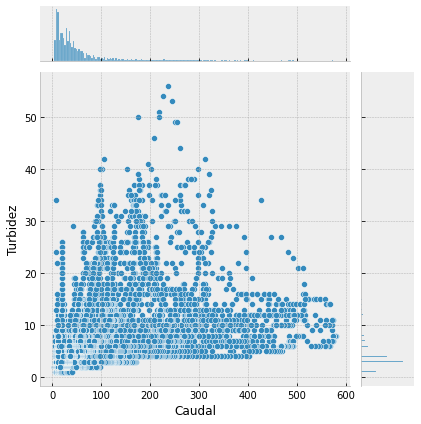

In [ ]:
sns.jointplot(x='Caudal',y='Turbidez',data=train_over)

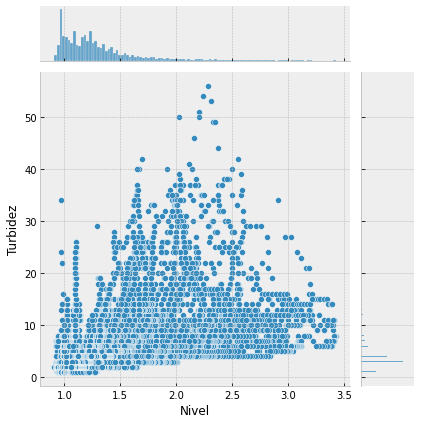

In [ ]:
sns.jointplot(x='Nivel',y='Turbidez',data=train_over)

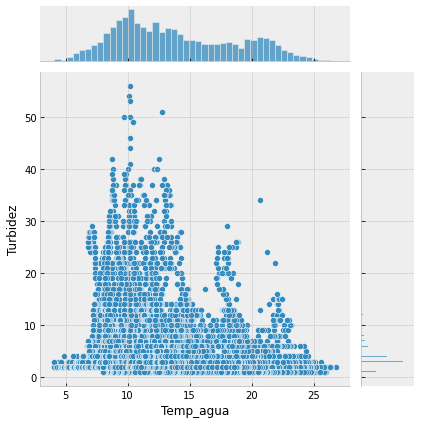

In [ ]:
sns.jointplot(x='Temp_agua',y='Turbidez',data=train_over)

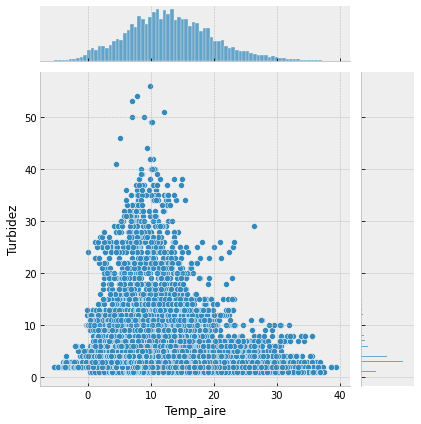

In [ ]:
sns.jointplot(x='Temp_aire',y='Turbidez',data=train_over)

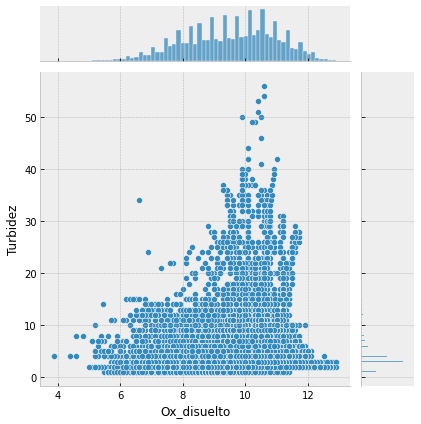

In [ ]:
sns.jointplot(x='Ox_disuelto',y='Turbidez',data=train_over)

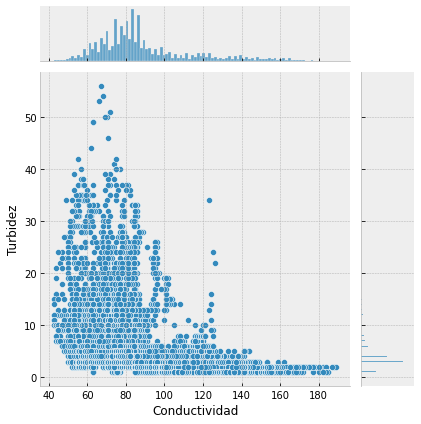

In [ ]:
sns.jointplot(x='Conductividad',y='Turbidez',data=train_over)

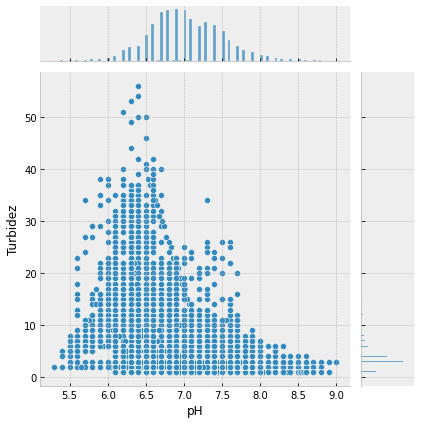

In [ ]:
sns.jointplot(x='pH',y='Turbidez',data=train_over)

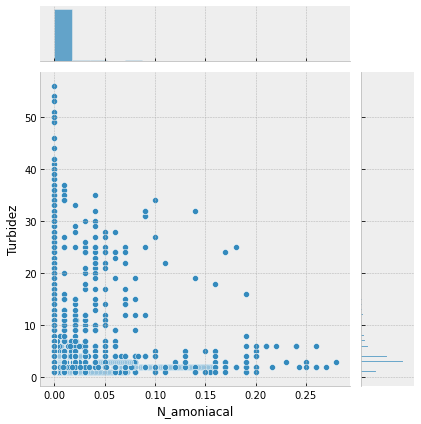

In [ ]:
sns.jointplot(x='N_amoniacal',y='Turbidez',data=train_over)

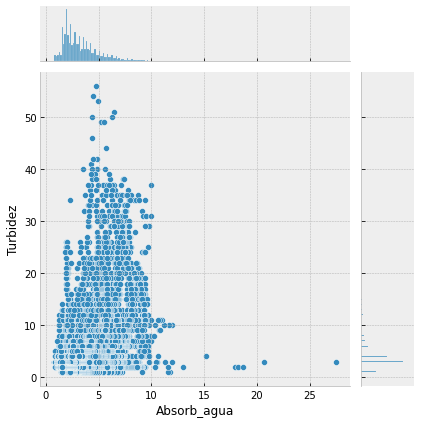

In [ ]:
sns.jointplot(x='Absorb_agua',y='Turbidez',data=train_over)

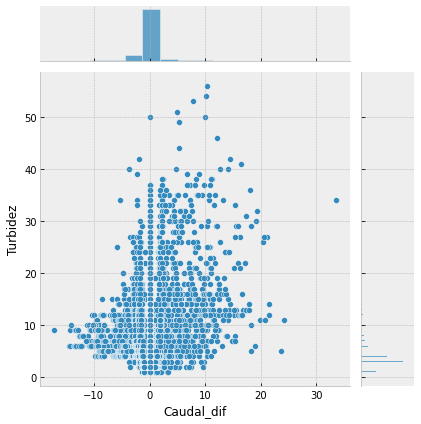

In [ ]:
sns.jointplot(x='Caudal_dif',y='Turbidez',data=train_over)

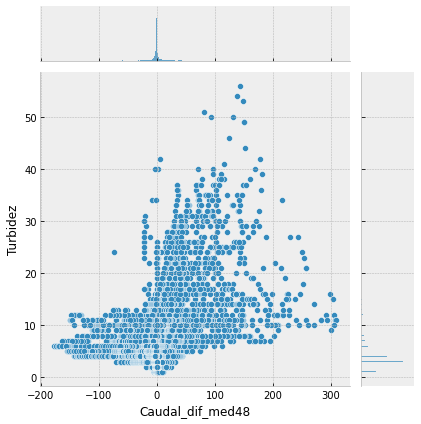

In [ ]:
sns.jointplot(x='Caudal_dif_med48',y='Turbidez',data=train_over)

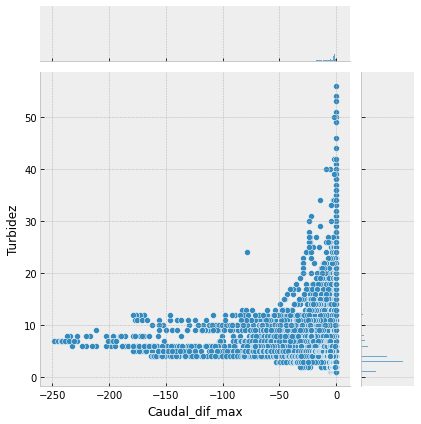

In [ ]:
sns.jointplot(x='Caudal_dif_max',y='Turbidez',data=train_over)

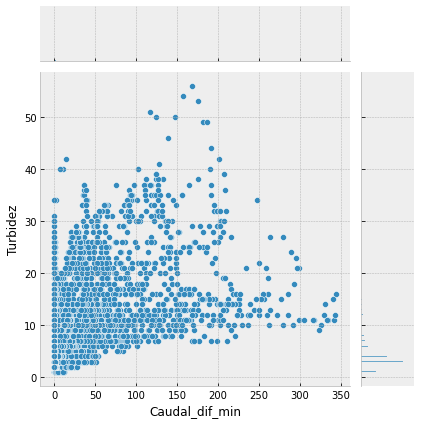

In [ ]:
sns.jointplot(x='Caudal_dif_min',y='Turbidez',data=train_over)

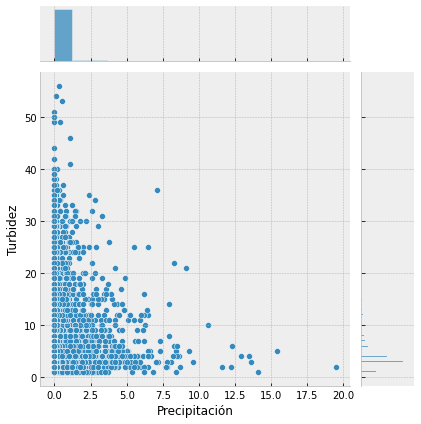

In [ ]:
sns.jointplot(x='Precipitación',y='Turbidez',data=train_over)

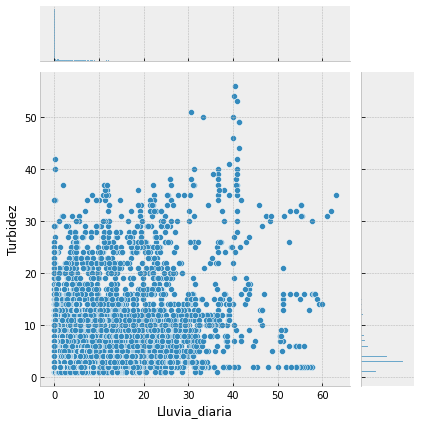

In [ ]:
sns.jointplot(x='Lluvia_diaria',y='Turbidez',data=train_over)

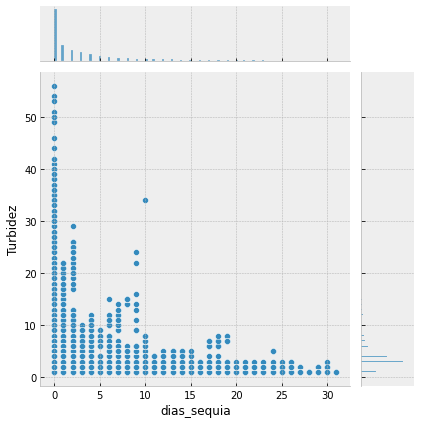

In [ ]:
sns.jointplot(x='dias_sequia',y='Turbidez',data=train_over)

#AUTOCORRELACIÓN Y ESTACIONARIEDAD

In [ ]:
muestras_dia=24 #Las horas de un dia
muestras_mes=720
muestras_estacion=2184

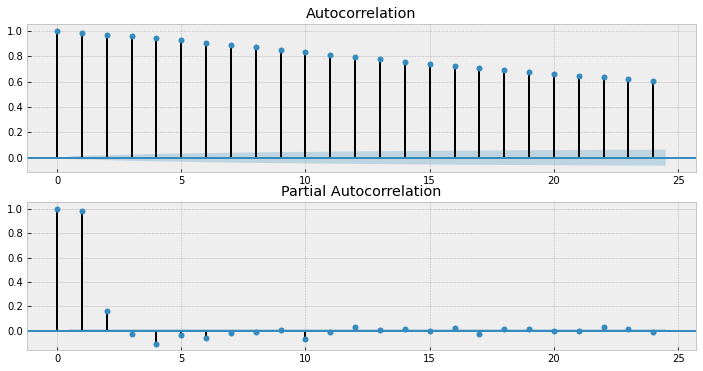

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train_over['Turbidez'], ax=ax[0], lags=muestras_dia)
ax[1] = plot_pacf(train_over['Turbidez'], ax=ax[1], lags=muestras_dia,)

In [ ]:
#lag=1 dia
statistic, p_value, n_lags, critical_values = kpss(train_over['Turbidez'], lags=muestras_dia)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critical Values:')
for key, value in critical_values.items():
  print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 2.5277174976089003
p-value: 0.01
num lags: 24
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [ ]:
#lag=1 mes
statistic, p_value, n_lags, critical_values = kpss(train_over['Turbidez'], lags=muestras_mes)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
  print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.35424695376640625
p-value: 0.09687631303172144
num lags: 720
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  


In [ ]:
#lag=1 estacion
statistic, p_value, n_lags, critical_values = kpss(train_over['Turbidez'], lags=muestras_estacion)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
  print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.23186509418864887
p-value: 0.1
num lags: 2184
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
dftest = adfuller(train_over['Turbidez'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Test statistic = -12.669
P-value = 0.000
Critical values :
	1%: -3.4305690321616815 - The data is  stationary with 99% confidence
	5%: -2.8616368062780313 - The data is  stationary with 95% confidence
	10%: -2.566821527030566 - The data is  stationary with 90% confidence


#SPLIT TRAIN/TEST

In [ ]:
test_over = train_over [ train_over.Fecha > '2021-09']
test_over.reset_index(drop=True, inplace=True)

In [ ]:
test_over.shape

(6527, 23)

In [ ]:
train_over2 = train_over [ train_over.Fecha < '2021-09']
train_over2.reset_index(drop=True, inplace=True)

,Fecha,Nivel,Caudal,Precipitación,Temp_aire,Temp_agua,Turbidez,Conductividad,pH,Ox_disuelto,N_amoniacal,Absorb_agua,mes,estacion,Turb_lag,Turb_dif,Caudal_dif,Caudal_dif_min,Caudal_dif_max,Caudal_dif_med48,Lluvia_diaria,Intensidad_lluvia,dias_sequia
23371,2021-08-31 19:00:00,0.98,9.09,0.0,24.9,22.5,1,142.0,7.2,8.1,0.0,2.6,Agosto,Verano,1.0,0.0,0.00,1.55,0.00,0.52,0.0,Inexistente,24
23372,2021-08-31 20:00:00,0.99,9.90,0.0,21.9,22.3,1,142.0,7.1,7.9,0.0,2.6,Agosto,Verano,1.0,0.0,0.81,2.36,0.00,1.30,0.0,Inexistente,24
23373,2021-08-31 21:00:00,0.99,9.90,0.0,20.1,22.2,1,143.0,7.2,8.1,0.0,2.6,Agosto,Verano,1.0,0.0,0.00,2.36,0.00,1.26,0.0,Inexistente,24
23374,2021-08-31 22:00:00,0.99,9.90,0.0,19.1,22.0,1,143.0,7.2,8.1,0.0,2.6,Agosto,Verano,1.0,0.0,0.00,2.36,0.00,1.23,0.0,Inexistente,24
23375,2021-08-31 23:00:00,0.98,9.09,0.0,18.7,21.9,1,143.0,7.3,8.3,0.0,2.6,Agosto,Verano,1.0,0.0,-0.81,1.55,-0.81,0.40,0.0,Inexistente,24


In [ ]:
test_over['Turbidez'][test_over['Turbidez']>=15].count()

88

In [ ]:
test_over['Turbidez'][test_over['Turbidez']>=25].count()

24

#MÉTRICAS DE ERROR

In [ ]:
#def mean_absolute_percentage_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def regression_results(y_true, y_pred):# Regression metrics
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    #mape=mean_absolute_percentage_error(y_true, y_pred) 
    #r2=metrics.r2_score(y_true, y_pred)
    #explained_variance=metrics.explained_variance_score(y_true, y_pred)
    #Escribe resultados
    #print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    #print('MAPE: ', round(mape,2))
    #print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,2))
    print('MSE: ', round(mse,2))
    print('RMSE: ', round(np.sqrt(mse),2))

#MODELOS

#REGRESION LINEAL

In [ ]:
selected_features = ['Nivel','Absorb_agua',
       'Conductividad','Temp_agua',
       'Lluvia_diaria','Caudal','Caudal_dif_med48','Caudal_dif_min', 'Caudal_dif_max','pH', 'Ox_disuelto']

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_over2[selected_features]) 
X_test = scaler.transform(test_over[selected_features])
y_train = train_over2['Turbidez']
y_test = test_over['Turbidez']

In [ ]:
'''X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(train_over2[selected_features].columns)
print(modelo.summary())'''

In [ ]:
'''scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_over2[selected_features]) 
X_test = scaler.transform(test_over[selected_features])
y_train = train_over2['Turbidez']
y_test = test_over['Turbidez']'''

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
print("Intercept:", model.intercept_)
print("Coeficiente:", list(zip(train_over2[selected_features].columns, model.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", model.score(X_train, y_train))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y = np.rint(y_pred)
y = y.astype(int) 
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0
y_pred_no_neg

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
y_pred_no_neg.mean()

3.2117358664011033

In [ ]:
y_pred_no_neg.max()

20

In [ ]:
errores_regresion_lineal =(y_test - y_pred_no_neg)

In [ ]:
regression_results(y_test, y_pred_no_neg)

MAE:  1.23
MSE:  5.07
RMSE:  2.25


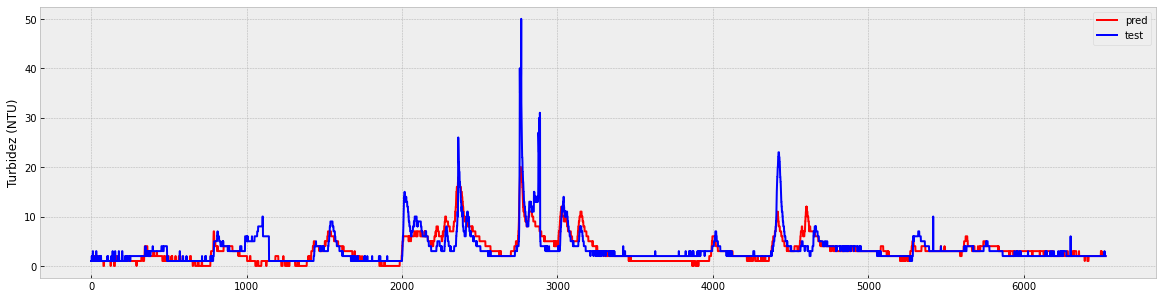

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_test.index, y_pred_no_neg, label='pred',color='red')
plt.plot(y_test.index, y_test, label='test',color='blue')
plt.ylabel('Turbidez (NTU)')
plt.legend()
plt.show()

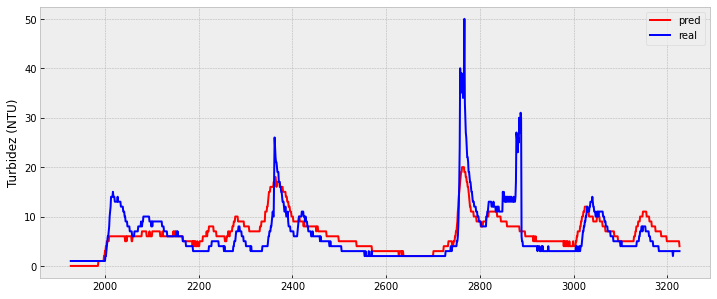

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index[-4600:-3300], y_pred_no_neg[-4600:-3300], label='pred',color='red')
plt.plot(y_test.index[-4600:-3300], y_test[-4600:-3300], label='real',color='blue')
plt.ylabel('Turbidez (NTU)')
plt.legend()
plt.show()

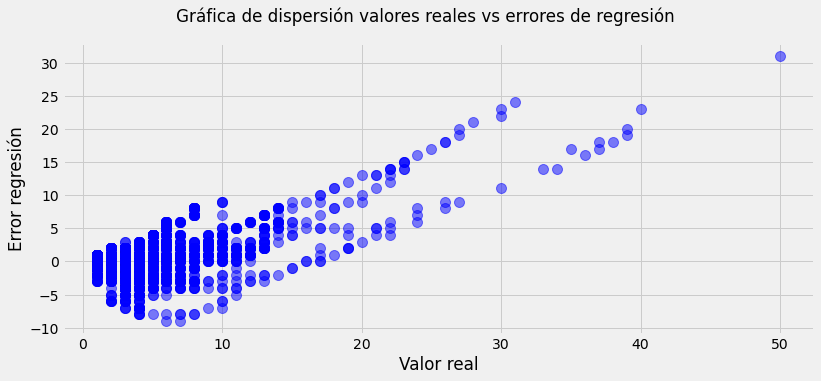

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(12, 5))
fig.suptitle('Gráfica de dispersión valores reales vs errores de regresión')
ax.scatter(y_test, errores_regresion_lineal, 
            color="blue",    
            s=100,           
            alpha=0.5,       
            linewidths=1)    
plt.xlabel('Valor real')
plt.ylabel('Error regresión')
plt.show()

In [ ]:
test_over['alarm1']=0
test_over['alarm_pred1']=0
for i in range (0,len(y_test)):
  if y_test[i] >= 15:
    test_over['alarm1'][i]=1
  if y_pred_no_neg[i] >= 15:
    test_over['alarm_pred1'][i]=1
y_alarm1_true=test_over['alarm1']
y_alarm1_pred=test_over['alarm_pred1']

In [ ]:
cm1 = confusion_matrix(y_alarm1_true, y_alarm1_pred)
cm1

array([[6420,   19],
       [  50,   38]])

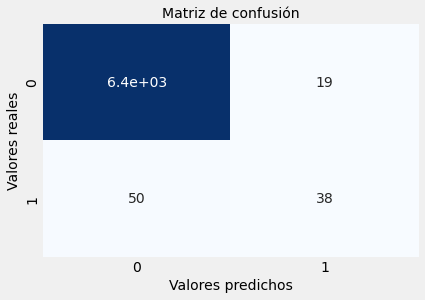

In [ ]:
sns.heatmap(cm1, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
#plt.tight_layout()
plt.ylabel("Valores reales", fontsize=14)
plt.xlabel("Valores predichos", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_alarm1_true, y_alarm1_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6439
           1       0.67      0.43      0.52        88

    accuracy                           0.99      6527
   macro avg       0.83      0.71      0.76      6527
weighted avg       0.99      0.99      0.99      6527



In [ ]:
#roc_auc_score(y_alarm1_true, y_alarm1_pred)

In [ ]:
test_over['alarm_pred2']=0
test_over['alarm2']=0
for i in range (0,len(y_test)):
  if y_test[i] >= 25:
    test_over['alarm2'][i]=1
  if y_pred_no_neg[i] >= 25:
    test_over['alarm_pred2'][i]=1
y_alarm2_true=test_over['alarm2']
y_alarm2_pred=test_over['alarm_pred2']

In [ ]:
cm2 = confusion_matrix(y_alarm2_true, y_alarm2_pred)
cm2

array([[6503,    0],
       [  24,    0]])

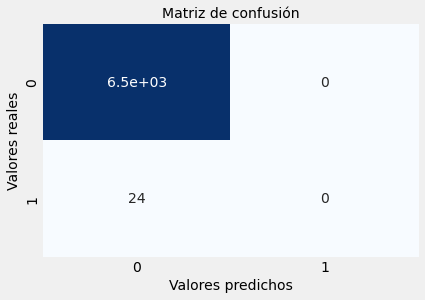

In [ ]:
sns.heatmap(cm2, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
#plt.tight_layout()
plt.ylabel("Valores reales", fontsize=14)
plt.xlabel("Valores predichos", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_alarm2_true, y_alarm2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6503
           1       0.00      0.00      0.00        24

    accuracy                           1.00      6527
   macro avg       0.50      0.50      0.50      6527
weighted avg       0.99      1.00      0.99      6527



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#GRADIENT BOOSTING REGRESSOR

In [ ]:
train_over2.columns

Index(['Fecha', 'Nivel', 'Caudal', 'Precipitación', 'Temp_aire', 'Temp_agua',
       'Turbidez', 'Conductividad', 'pH', 'Ox_disuelto', 'N_amoniacal',
       'Absorb_agua', 'mes', 'estacion', 'Turb_lag', 'Turb_dif', 'Caudal_dif',
       'Caudal_dif_min', 'Caudal_dif_max', 'Caudal_dif_med48', 'Lluvia_diaria',
       'Intensidad_lluvia', 'dias_sequia'],
      dtype='object')

In [ ]:
selected_features=['Nivel','Caudal', 'Temp_agua',
        'Conductividad', 'pH', 'Ox_disuelto',
       'Absorb_agua', 'Lluvia_diaria','Caudal_dif_min', 'Caudal_dif_max',
       'Caudal_dif_med48']

In [ ]:
'''param_dist = {
 "n_estimators": [8,16, 32, 64, 128, 256],
 "learning_rate" : [0.01,0.03,0.05,0.1],
  "max_features" : ["auto", "sqrt"],
  "max_depth" : [3,4,6],
 "loss" : ['squared_error', 'huber', 'lad', 'quantile']
 #"criterion": ['mae', 'friedman_mse']
 }'''


In [ ]:
'''grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid = param_dist, cv=5)
grid_gb.fit(X = train_over2[selected_features], y = train_over2['Turbidez'])'''

In [ ]:
'''def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")'''

In [ ]:
'''report(grid_gb.cv_results_, n_top = 10)'''

Model with rank: 1
Mean validation score: 0.602 (std: 0.180)
Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 128}

Model with rank: 2
Mean validation score: 0.600 (std: 0.179)
Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 128}

Model with rank: 3
Mean validation score: 0.597 (std: 0.172)
Parameters: {'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 256}

Model with rank: 4
Mean validation score: 0.597 (std: 0.172)
Parameters: {'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 256}

Model with rank: 5
Mean validation score: 0.596 (std: 0.170)
Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 64}

Model with rank: 6
Mean validation score: 0.596 (std: 0.178)
Parameters: {'learning_rate': 0.05, 'loss': 'huber', 'max_depth

In [ ]:
'''best_gb = grid_gb.best_estimator_
print (best_gb)'''

In [ ]:
best_gb= GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=3,
                          max_features='auto', n_estimators=128,
                          random_state=0,)

In [ ]:
best_gb.fit( X = train_over2[selected_features], y = train_over2['Turbidez'])
y_pred = best_gb.predict(X = test_over[selected_features])

In [ ]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
relevancia=pd.DataFrame({'Attributes': ('Nivel','Caudal', 'Temp_agua',
        'Conductividad', 'pH', 'Ox_disuelto',
       'Absorb_agua', 'Lluvia_diaria','Caudal_dif_min', 'Caudal_dif_max',
       'Caudal_dif_med48') ,
              'Decision Tree': best_gb.feature_importances_})

Feature Relevancies


In [ ]:
relevancia.groupby('Attributes')['Decision Tree'].sum().sort_values(ascending=False)#con sequia

Attributes
Caudal              0.431529
Absorb_agua         0.099095
Caudal_dif_med48    0.098884
Conductividad       0.085844
Nivel               0.063050
Caudal_dif_min      0.059602
pH                  0.043294
Caudal_dif_max      0.036570
Temp_agua           0.032475
Ox_disuelto         0.029091
Lluvia_diaria       0.020566
Name: Decision Tree, dtype: float64

In [ ]:
y = np.rint(y_pred) 
y = y.astype(int) 
res = np.hstack(y)
res

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0
y_pred_no_neg

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
y_pred_no_neg.mean()

3.490424390991267

In [ ]:
y_pred_no_neg.max()

26

In [ ]:
y_test=test_over['Turbidez']

In [ ]:
regression_results(y_test, y_pred_no_neg)

MAE:  1.15
MSE:  5.18
RMSE:  2.27


In [ ]:
errores_GBDT =(y_test - y_pred_no_neg)

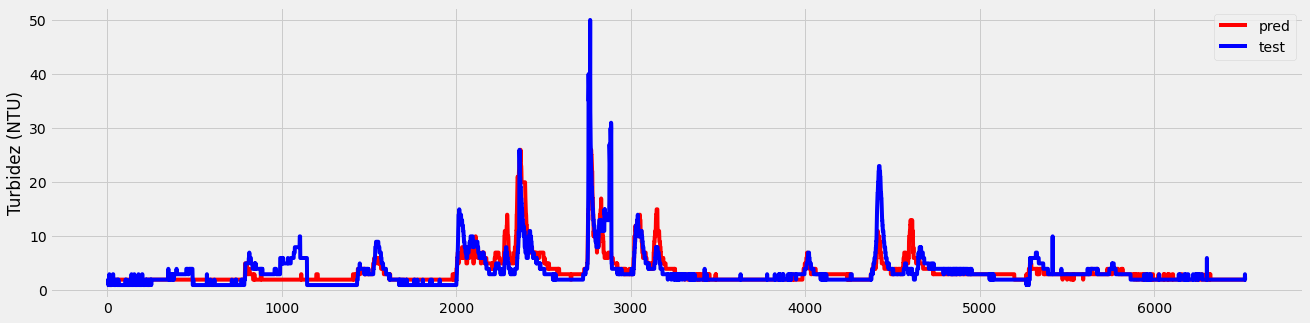

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_test.index, y_pred_no_neg, label='pred',color='red')
plt.plot(y_test.index, y_test, label='test',color='blue')
plt.ylabel('Turbidez (NTU)')
plt.legend()
plt.show()

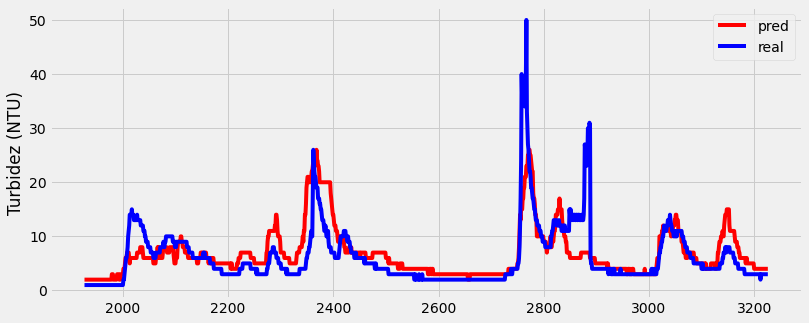

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index[-4600:-3300], y_pred_no_neg[-4600:-3300], label='pred',color='red')
plt.plot(y_test.index[-4600:-3300], y_test[-4600:-3300], label='real',color='blue')
plt.ylabel('Turbidez (NTU)')
plt.legend()
plt.show()

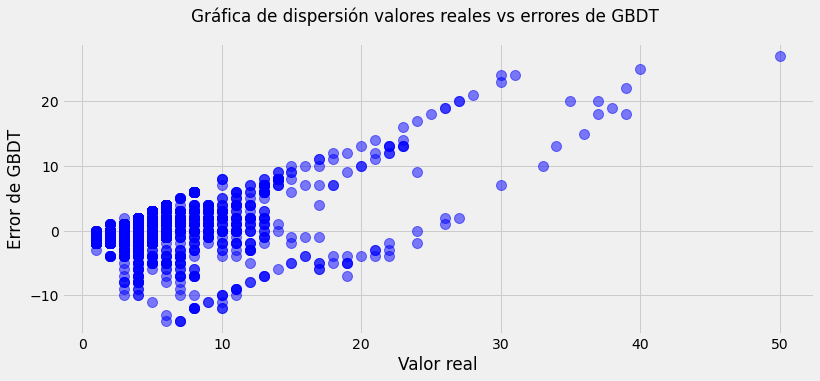

In [ ]:
#Gráfico de dispersión errores frente a valores real
plt.close()
fig, ax = plt.subplots(1, figsize=(12, 5))
fig.suptitle('Gráfica de dispersión valores reales vs errores de GBDT')
ax.scatter(y_test, errores_GBDT, 
            color="blue",    
            s=100,           
            alpha=0.5,       
            linewidths=1)    
plt.xlabel('Valor real')
plt.ylabel('Error de GBDT')
plt.show()


In [ ]:
test_over['alarm1']=0
test_over['alarm_pred1']=0
for i in range (0,len(y_test)):
  if y_test[i] >= 15:
    test_over['alarm1'][i]=1
  if y_pred_no_neg[i] >= 15:
    test_over['alarm_pred1'][i]=1
y_alarm1_true=test_over['alarm1']
y_alarm1_pred=test_over['alarm_pred1']

In [ ]:
cm1 = confusion_matrix(y_alarm1_true, y_alarm1_pred)
cm1

array([[6392,   47],
       [  44,   44]])

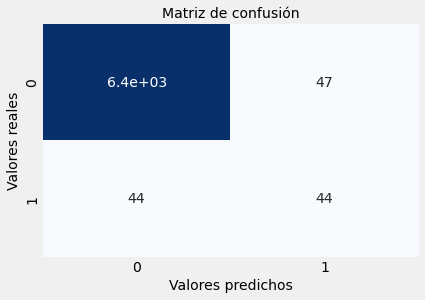

In [ ]:
sns.heatmap(cm1, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
#plt.tight_layout()
plt.ylabel("Valores reales", fontsize=14)
plt.xlabel("Valores predichos", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_alarm1_true, y_alarm1_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6439
           1       0.48      0.50      0.49        88

    accuracy                           0.99      6527
   macro avg       0.74      0.75      0.74      6527
weighted avg       0.99      0.99      0.99      6527



In [ ]:
#roc_auc_score(y_alarm1_true, y_alarm1_pred)

0.7463503649635036

In [ ]:
test_over['alarm_pred2']=0
test_over['alarm2']=0
for i in range (0,len(y_test)):
  if y_test[i] >= 25:
    test_over['alarm2'][i]=1
  if y_pred_no_neg[i] >= 25:
    test_over['alarm_pred2'][i]=1
y_alarm2_true=test_over['alarm2']
y_alarm2_pred=test_over['alarm_pred2']

In [ ]:
cm2 = confusion_matrix(y_alarm2_true, y_alarm2_pred)
cm2

array([[6498,    5],
       [  22,    2]])

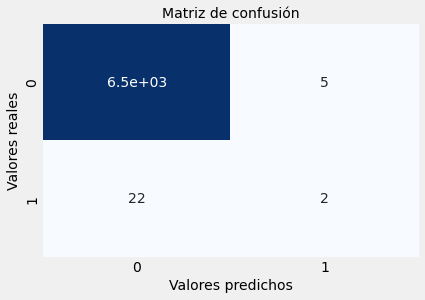

In [ ]:
sns.heatmap(cm2, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
#plt.tight_layout()
plt.ylabel("Valores reales", fontsize=14)
plt.xlabel("Valores predichos", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_alarm2_true, y_alarm2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6503
           1       0.29      0.08      0.13        24

    accuracy                           1.00      6527
   macro avg       0.64      0.54      0.56      6527
weighted avg       0.99      1.00      0.99      6527



In [ ]:
#roc_auc_score(y_alarm2_true, y_alarm2_pred)

0.541282228714952

#LSTM

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
train_over2.columns

Index(['Fecha', 'Nivel', 'Caudal', 'Precipitación', 'Temp_aire', 'Temp_agua',
       'Turbidez', 'Conductividad', 'pH', 'Ox_disuelto', 'N_amoniacal',
       'Absorb_agua', 'mes', 'estacion', 'Turb_lag', 'Turb_dif', 'Caudal_dif',
       'Caudal_dif_min', 'Caudal_dif_max', 'Caudal_dif_med48', 'Lluvia_diaria',
       'Intensidad_lluvia', 'dias_sequia'],
      dtype='object')

In [ ]:
selected_features=['Nivel','Caudal', 'Temp_agua',
        'Conductividad', 'pH', 'Ox_disuelto',
       'Absorb_agua', 'Lluvia_diaria','Caudal_dif_min', 'Caudal_dif_max', 'Caudal_dif_med48']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(train_over2[selected_features]) 
X_test = scaler.transform(test_over[selected_features])
y_train = train_over2['Turbidez']
y_test = test_over['Turbidez']


In [ ]:
n_features = train_over2[selected_features].shape[1]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(23376, 1, 11)

In [ ]:
X_test.shape

(6527, 1, 11)

In [ ]:
from keras.callbacks import learning_rate_schedule
from keras import optimizers
units=32
epochs=250
batch_size=250
model = Sequential()
model.add(LSTM(units=units, return_sequences=True, input_shape=(1, n_features),seed=1))
#model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/250
94/94 - 2s - loss: 32.7465 - 2s/epoch - 19ms/step
Epoch 2/250
94/94 - 0s - loss: 21.1010 - 141ms/epoch - 1ms/step
Epoch 3/250
94/94 - 0s - loss: 16.9037 - 140ms/epoch - 1ms/step
Epoch 4/250
94/94 - 0s - loss: 15.2857 - 138ms/epoch - 1ms/step
Epoch 5/250
94/94 - 0s - loss: 13.4166 - 168ms/epoch - 2ms/step
Epoch 6/250
94/94 - 0s - loss: 11.8823 - 152ms/epoch - 2ms/step
Epoch 7/250
94/94 - 0s - loss: 10.9817 - 145ms/epoch - 2ms/step
Epoch 8/250
94/94 - 0s - loss: 10.4473 - 147ms/epoch - 2ms/step
Epoch 9/250
94/94 - 0s - loss: 10.0857 - 147ms/epoch - 2ms/step
Epoch 10/250
94/94 - 0s - loss: 9.8198 - 143ms/epoch - 2ms/step
Epoch 11/250
94/94 - 0s - loss: 9.6167 - 139ms/epoch - 1ms/step
Epoch 12/250
94/94 - 0s - loss: 9.4432 - 146ms/epoch - 2ms/step
Epoch 13/250
94/94 - 0s - loss: 9.2861 - 146ms/epoch - 2ms/step
Epoch 14/250
94/94 - 0s - loss: 9.1323 - 140ms/epoch - 1ms/step
Epoch 15/250
94/94 - 0s - loss: 8.9844 - 143ms/epoch - 2ms/step
Epoch 16/250
94/94 - 0s - loss: 8.8350 - 1

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [ ]:
trainPredict.shape

(23376, 1, 1)

In [ ]:
testPredict.shape

(6527, 1, 1)

In [ ]:
trainPredict2=trainPredict[:,0,0]

In [ ]:
testPredict2=testPredict[:,0,0]

In [ ]:
trainPredict2[trainPredict2 < 0] = 0 
regression_results(y_train, trainPredict2)

MAE:  1.18
MSE:  4.72
RMSE:  2.17


In [ ]:
y=np.rint(testPredict2)
y = y.astype(int) 
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred_no_neg < 0] = 0
y_pred_no_neg

array([1, 1, 1, ..., 3, 3, 3])

In [ ]:
y_pred_no_neg.mean()

3.7184004902711814

In [ ]:
y_pred_no_neg.max()

35

In [ ]:
regression_results(y_test, y_pred_no_neg)

MAE:  1.25
MSE:  4.98
RMSE:  2.23


In [ ]:
errores_LSTM =(y_test - y_pred_no_neg)

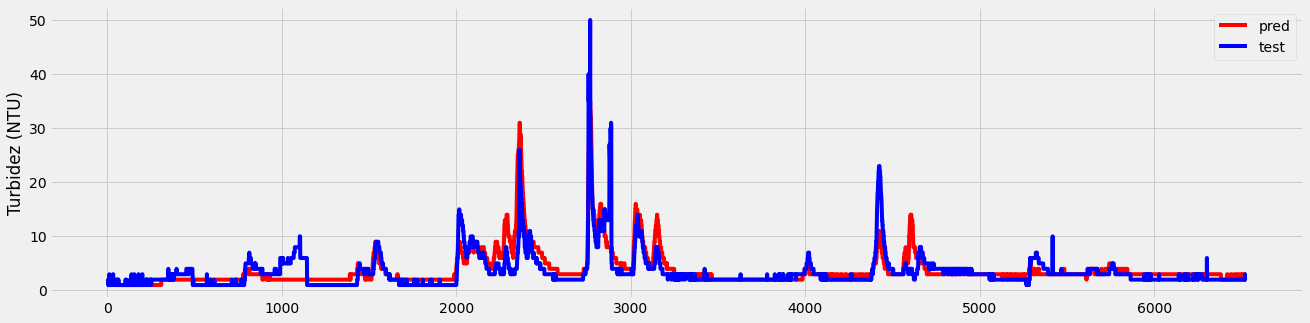

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_test.index, y_pred_no_neg, label='pred',color='red')
plt.plot(y_test.index, y_test, label='test',color='blue')
plt.ylabel('Turbidez (NTU)')
plt.legend()
plt.show()

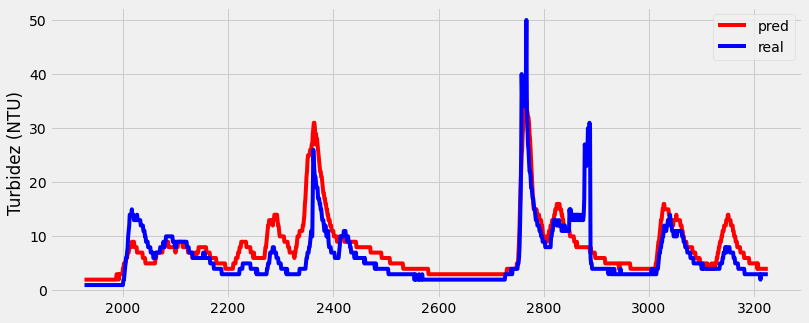

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index[-4600:-3300], y_pred_no_neg[-4600:-3300], label='pred',color='red')
plt.plot(y_test.index[-4600:-3300], y_test[-4600:-3300], label='real',color='blue')
plt.ylabel('Turbidez (NTU)')
plt.legend()
plt.show()

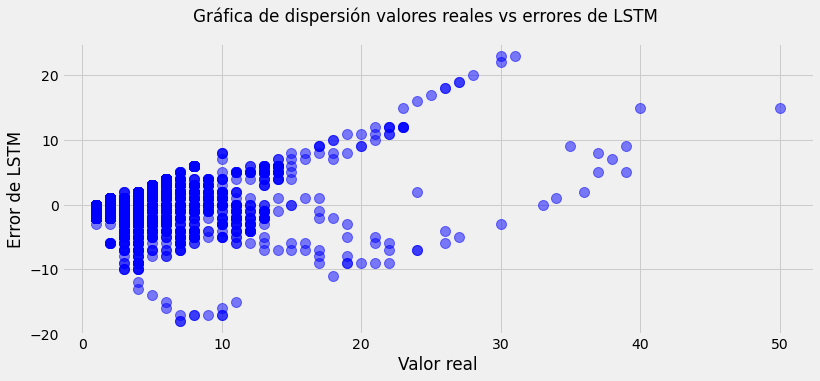

In [ ]:
plt.close()
fig, ax = plt.subplots(1, figsize=(12, 5))
fig.suptitle('Gráfica de dispersión valores reales vs errores de LSTM')
ax.scatter(y_test, errores_LSTM, 
            color="blue",    
            s=100,           
            alpha=0.5,       
            linewidths=1)    
plt.xlabel('Valor real')
plt.ylabel('Error de LSTM')
plt.show()


In [ ]:
test_over['alarm1']=0
test_over['alarm_pred1']=0
for i in range (0,len(y_test)):
  if y_test[i] >= 15:
    test_over['alarm1'][i]=1
  if y_pred_no_neg[i] >= 15:
    test_over['alarm_pred1'][i]=1
y_alarm1_true=test_over['alarm1']
y_alarm1_pred=test_over['alarm_pred1']

In [ ]:
cm1 = confusion_matrix(y_alarm1_true, y_alarm1_pred)
cm1

array([[6386,   53],
       [  43,   45]])

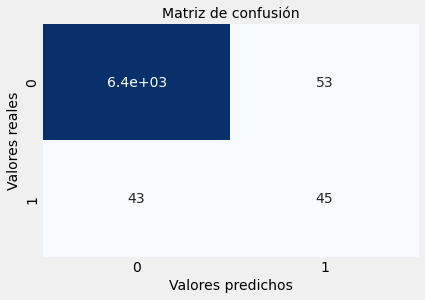

In [ ]:
sns.heatmap(cm1, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
#plt.tight_layout()
plt.ylabel("Valores reales", fontsize=14)
plt.xlabel("Valores predichos", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_alarm1_true, y_alarm1_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6439
           1       0.46      0.51      0.48        88

    accuracy                           0.99      6527
   macro avg       0.73      0.75      0.74      6527
weighted avg       0.99      0.99      0.99      6527



In [ ]:
#roc_auc_score(y_alarm1_true, y_alarm1_pred)

0.7515662722895988

In [ ]:
test_over['alarm_pred2']=0
test_over['alarm2']=0
for i in range (0,len(y_test)):
  if y_test[i] >= 25:
    test_over['alarm2'][i]=1
  if y_pred_no_neg[i] >= 25:
    test_over['alarm_pred2'][i]=1
y_alarm2_true=test_over['alarm2']
y_alarm2_pred=test_over['alarm_pred2']

In [ ]:
cm2 = confusion_matrix(y_alarm2_true, y_alarm2_pred)
cm2

array([[6479,   24],
       [   9,   15]])

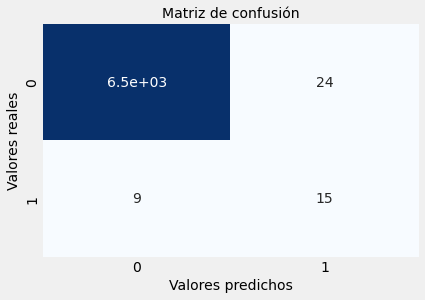

In [ ]:
sns.heatmap(cm2, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
#plt.tight_layout()
plt.ylabel("Valores reales", fontsize=14)
plt.xlabel("Valores predichos", fontsize=14)
plt.show()

In [ ]:
print(classification_report(y_alarm2_true, y_alarm2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6503
           1       0.38      0.62      0.48        24

    accuracy                           0.99      6527
   macro avg       0.69      0.81      0.74      6527
weighted avg       1.00      0.99      1.00      6527



In [ ]:
#roc_auc_score(y_alarm2_true, y_alarm2_pred)

0.81065469783177